In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.gaussian_process.kernels import ConstantKernel as C, RBF, Matern
from scipy.stats import norm
from scipy.spatial.distance import cdist
import odor_stat_calculations as osc
from scipy.stats import kurtosis

import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import FigureLayout,mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

from itertools import groupby
from operator import itemgetter


In [ ]:
def predict_odor_concentration(x, y, fitted_p_heatmap, xedges, yedges, fdf, fdf_nowhiff,
                               distance_threshold=4, rows_per_second=200, base_odor_level=0.58):
    """
    Predict the odor concentration for given test locations (x, y).
    """
    df_test = pd.DataFrame({'distance_along_streakline': x, 'nearest_from_streakline': y})
    
    odor_concentration_samples = np.full(len(df_test), base_odor_level)
    whiff_prediction_samples = np.zeros(len(df_test), dtype=int)
    
    test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
    whiff_locations = fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
    nowhiff_locations = fdf_nowhiff[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
    
    whiff_means = fdf.mean_concentration.values
    whiff_stds = fdf.std_whiff.values
    whiff_duration = fdf.length_of_encounter.values
    nowhiff_means = fdf_nowhiff.wc_nowhiff.values
    nowhiff_wsd = fdf_nowhiff.wsd_nowhiff.values
    
    distances = cdist(test_locations, whiff_locations)
    distances_nowhiff = cdist(test_locations, nowhiff_locations)

    def moving_average(data, window_size):
        if window_size < 1 or len(data) < window_size:
            return data
        window = np.ones(int(window_size)) / float(window_size)
        return np.convolve(data, window, 'same')

    i = 0
    while i < len(df_test):
        dist_along, nearest_from = df_test.iloc[i][['distance_along_streakline', 'nearest_from_streakline']]
        whiff_predicted, whiff_prob = predict_whiff_from_probability(dist_along, nearest_from,
                                                                     fitted_p_heatmap, xedges, yedges)
        if whiff_predicted and np.min(distances[i]) <= distance_threshold:
            nearest_whiff_idx = np.argmin(distances[i])
            mean_concentration = whiff_means[nearest_whiff_idx]
            std_dev_whiff = whiff_stds[nearest_whiff_idx]
            duration = int(whiff_duration[nearest_whiff_idx] * rows_per_second)
            rows_to_fill = min(duration, len(df_test) - i)

            generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
            generated_concentrations = np.clip(generated_concentrations, 4, 10.2)
            odor_concentration_samples[i:i + rows_to_fill] = generated_concentrations
            whiff_prediction_samples[i:i + rows_to_fill] = 1
            i += rows_to_fill
        else:
            i += 1

    i = 0
    while i < len(df_test):
        if odor_concentration_samples[i] == base_odor_level:
            nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
            no_whiff_mean = nowhiff_means[nearest_no_whiff_idx]
            no_whiff_std = nowhiff_wsd[nearest_no_whiff_idx]

            start = i
            while i < len(df_test) and odor_concentration_samples[i] == base_odor_level:
                i += 1
            end = i

            no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start)
            no_whiff_concentrations = np.clip(no_whiff_concentrations, 0.58, 1)
            smoothed_concentrations = moving_average(no_whiff_concentrations, window_size=5)

            odor_concentration_samples[start:end] = smoothed_concentrations
        else:
            i += 1

    df_test['predicted_odor'] = odor_concentration_samples
    df_test['whiff_predicted'] = whiff_prediction_samples

    return df_test

def predict_whiff_from_probability(x, y, hmap, xedges, yedges):
    x_bin = np.digitize(x, xedges) - 1  # -1 because digitize returns 1-based index
    y_bin = np.digitize(y, yedges) - 1

    if x_bin < 0 or x_bin >= hmap.shape[0] or y_bin < 0 or y_bin >= hmap.shape[1]:
        return False, 0  # No valid bin, so no whiff predicted, probability is 0
    whiff_prob = hmap[x_bin, y_bin]
    whiff_predicted = np.random.rand() < whiff_prob  # True if random number is less than the probability

    return whiff_predicted, whiff_prob


In [56]:
# Example usage
if __name__ == "__main__":
    dirname = '../data/simulator/'
    hmap_data = np.load(str(dirname) + "hws_hmap_with_edges.npz")
    fitted_p_heatmap=hmap_data['fitted_p_heatmap']
    fdf_file = pd.read_hdf(str(dirname) + 'hws_whiff.h5')
    fdf_nowhiff_file = pd.read_hdf(str(dirname) + 'hws_nowhiff.h5')
    
    fdf = fdf_file
    fdf_nowhiff = fdf_nowhiff_file
    
    df = pd.read_hdf('/home/gorilla/An/data/WindyMASigned.h5')
    df['distance_along_streakline']=df.distance_along_streakline*df.xsign
    df['nearest_from_streakline']=df.nearest_from_streakline*df.ysign
       
    # n_bins_x = n_bins_y = 50
    # xedges = np.linspace(0, 50, n_bins_x + 1)
    # yedges = np.linspace(-25, 25, n_bins_y + 1)
    xedges = hmap_data['xedges']
    yedges = hmap_data['yedges']

    df_test=df[10000:]
    df_test.reset_index(inplace=True, drop=True)
    x = df_test.distance_along_streakline # Example x values
    y = df_test.nearest_from_streakline
    predicted_df = predict_odor_concentration(x, y, fitted_p_heatmap, xedges, yedges, fdf, fdf_nowhiff)
    
    df_test['predicted_odor']=predicted_df.predicted_odor
    df_test['whiff_predicted']=predicted_df.whiff_predicted

/tmp/ipykernel_1075276/4105340787.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted_odor']=predicted_df.predicted_odor
/tmp/ipykernel_1075276/4105340787.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['whiff_predicted']=predicted_df.whiff_predicted


In [57]:
th=4.5
query1 = 'odor>4.5'
new_test_df1=pd.DataFrame()
new_test_df1 = df_test.query(query1)
new_test_df1.reset_index(inplace=True, drop=True)

query2 = 'predicted_odor>4.5'
new_test_df2=pd.DataFrame()
new_test_df2 = df_test.query(query2)
new_test_df2.reset_index(inplace=True, drop=True)

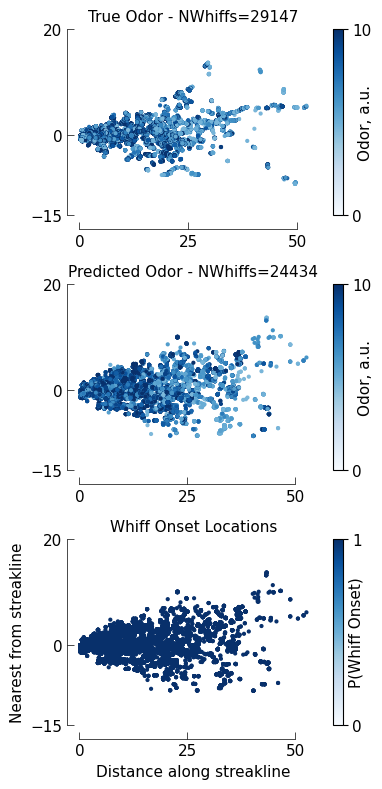

In [58]:
f, ax = plt.subplots(3, 1, figsize=(4, 8))

cax1 = ax[0].scatter(new_test_df1.distance_along_streakline, new_test_df1.nearest_from_streakline, c=new_test_df1.odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax2 = ax[1].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.predicted_odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax3 = ax[2].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.whiff_predicted, s = 4, cmap='Blues', vmin=0, vmax=1)
# ylim=(-15,25)

ax[0].set_title('True Odor - NWhiffs='+str(len(new_test_df1)))
ax[1].set_title('Predicted Odor - NWhiffs='+str(len(new_test_df2)))
ax[2].set_title('Whiff Onset Locations')
ax[2].set_xlabel('Distance along streakline')
ax[2].set_ylabel('Nearest from streakline')

cb1=plt.colorbar(cax1)
cb2=plt.colorbar(cax2)
cb3=plt.colorbar(cax3)

cb1.set_label('Odor, a.u.',labelpad=-10)
cb2.set_label('Odor, a.u.',labelpad=-10)
cb3.set_label('P(Whiff Onset)',labelpad=-10)

cb1.set_ticks([0,10])
cb2.set_ticks([0,10])
cb3.set_ticks([0, 1])
for i in range(3):
    mpl_functions.adjust_spines(ax[i],['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0,25,50],
                            yticks=[-15,0,20],
                            linewidth=0.5)
    mpl_functions.set_fontsize(ax[i],11)

f.tight_layout()

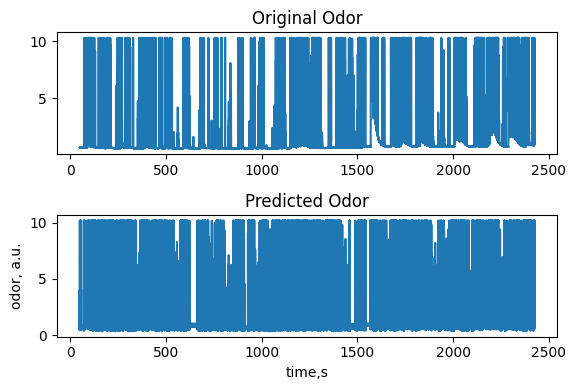

In [59]:
f,(ax1,ax2)= plt.subplots(2,1,figsize=(6,4))
ax1.plot(df_test.time, df_test.odor, label='original')
# plt.plot(df_test.smoothed_odor, label='smoothed')
ax2.plot(df_test.time, df_test.predicted_odor, label='predicted')
# ax2.axhline(4, color = 'r', linestyle = '--')

# limit=(1100,1120)
# limit = (58,65)
# ax1.set_xlim(limit)
# ax2.set_xlim(limit)
# ax2.set_ylim(0,1)

ax2.set_ylabel('odor, a.u.')
ax2.set_xlabel('time,s')
ax1.set_title('Original Odor')
ax2.set_title('Predicted Odor')
f.tight_layout()

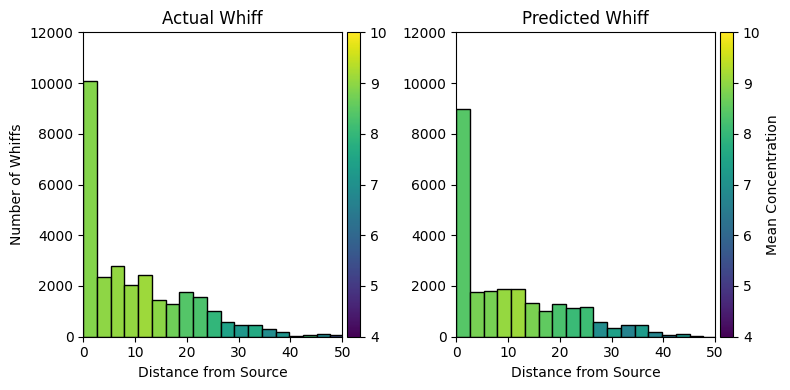

In [60]:
n_bins = 20
ylim = (0,12000)
# Actual Whiff Data
df_actual = new_test_df1.copy()
bins = np.linspace(0, df_actual['distance_from_source'].max(), n_bins + 1)
df_actual['distance_bin'] = pd.cut(df_actual['distance_from_source'], bins=bins)

whiff_counts_actual = df_actual.groupby('distance_bin').size()
mean_concentrations_actual = df_actual.groupby('distance_bin')['odor'].mean()
bin_centers_actual = (bins[:-1] + bins[1:]) / 2

# Predicted Whiff Data
df_predicted = new_test_df2.copy()
bins_predicted = np.linspace(0, df_predicted['distance_from_source'].max(), n_bins + 1)
df_predicted['distance_bin'] = pd.cut(df_predicted['distance_from_source'], bins=bins_predicted)

whiff_counts_predicted = df_predicted.groupby('distance_bin').size()
mean_concentrations_predicted = df_predicted.groupby('distance_bin')['predicted_odor'].mean()
bin_centers_predicted = (bins_predicted[:-1] + bins_predicted[1:]) / 2

# Create the subplots
f, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot for Actual Whiff Data
norm_actual = plt.Normalize(4, 10)
colors_actual = plt.cm.viridis(norm_actual(mean_concentrations_actual))
bars_actual = ax[0].bar(bin_centers_actual, whiff_counts_actual, width=(bins[1] - bins[0]), edgecolor='black', color=colors_actual)

divider_actual = make_axes_locatable(ax[0])
cax_actual = divider_actual.append_axes("right", size="5%", pad=0.05)
sm_actual = plt.cm.ScalarMappable(cmap='viridis', norm=norm_actual)
sm_actual.set_array([])
cbar_actual = plt.colorbar(sm_actual, cax=cax_actual)
# cbar_actual.set_label('Mean Concentration')

ax[0].set_xlabel('Distance from Source')
ax[0].set_ylabel('Number of Whiffs')
ax[0].set_title('Actual Whiff')
ax[0].set_ylim(ylim)
ax[0].set_xlim(0,50)
# Plot for Predicted Whiff Data
norm_predicted = plt.Normalize(4, 10)
colors_predicted = plt.cm.viridis(norm_predicted(mean_concentrations_predicted))
bars_predicted = ax[1].bar(bin_centers_predicted, whiff_counts_predicted, width=(bins_predicted[1] - bins_predicted[0]), edgecolor='black', color=colors_predicted)

divider_predicted = make_axes_locatable(ax[1])
cax_predicted = divider_predicted.append_axes("right", size="5%", pad=0.05)
sm_predicted = plt.cm.ScalarMappable(cmap='viridis', norm=norm_predicted)
sm_predicted.set_array([])
cbar_predicted = plt.colorbar(sm_predicted, cax=cax_predicted)
cbar_predicted.set_label('Mean Concentration')

ax[1].set_xlabel('Distance from Source')
ax[1].set_title('Predicted Whiff')
ax[1].set_ylim(ylim)
ax[1].set_xlim(0,50)
f.tight_layout()

